## Imports
This installs all required tools and libraries

In [2]:
import torch
import random
import numpy
import os
import time
import pygame
import matplotlib.pyplot as plt
from collections import deque
from maze_game import Game
from model import Linear_QNet, QTrainer
from IPython import get_ipython
from enum import Enum

pygame 2.5.2 (SDL 2.28.3, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html


## Maze Game Class
This is responsible for storing and visualizing the agent's environment. It also calculates reward values for each move the agent makes.

In [3]:
sourceFileDir = os.path.dirname(os.path.abspath(""))
switch_mazes = False

class Game():
    SIZE = (500, 500)
    TILE_SIZE = 45.5

    def __init__(self):
        pygame.init()
        self.screen = pygame.display.set_mode(Game.SIZE)
        self.textures = [
            pygame.transform.scale(pygame.image.load(os.path.join(sourceFileDir, "reinforcement_learning/resources/wall.jpg")), (Game.TILE_SIZE + 1, Game.TILE_SIZE + 1)),
            pygame.transform.scale(pygame.image.load(os.path.join(sourceFileDir, "reinforcement_learning/resources/road.jpg")), (Game.TILE_SIZE + 1, Game.TILE_SIZE + 1)),
            pygame.transform.scale(pygame.image.load(os.path.join(sourceFileDir, "reinforcement_learning/resources/path.png")), (Game.TILE_SIZE + 1, Game.TILE_SIZE + 1)),
            pygame.transform.scale(pygame.image.load(os.path.join(sourceFileDir, "reinforcement_learning/resources/player.png")), (Game.TILE_SIZE + 1, Game.TILE_SIZE + 1))
        ]

        self.level = 1
        self.load_level(self.level)
        self.reset()

    # Loads tilemap from .maze type file and sets up the environment
    def load_level(self, level):
        self.tilemap = numpy.loadtxt(os.path.join(sourceFileDir, "reinforcement_learning/dataset/matrices/" + str(level) + ".maze"), delimiter=',', dtype=numpy.int8)
        self.map_width = len(self.tilemap[0])
        self.map_height = len(self.tilemap)
        self.min_reward = -0.5 * self.map_width * self.map_height
        self.num_games = 0

    # Resets the environment on game over
    def reset(self):
        self.path = [[1, 1]]
        self.pathed_tilemap = self.tilemap.copy().astype(float)
        self.pathed_tilemap[1][1] = 0.3 # Starting position
        self.moves = 0
        self.total_reward = 0

    # Performs visual updates to Pygame display
    def run(self):
        self.draw_map()
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
            if event.type == pygame.KEYDOWN:
                if event.key == pygame.K_UP:
                    self.play_step(1, 0, 0, 0)
                elif event.key == pygame.K_RIGHT:
                    self.play_step(0, 1, 0, 0)
                elif event.key == pygame.K_DOWN:
                    self.play_step(0, 0, 1, 0)
                elif event.key == pygame.K_LEFT:
                    self.play_step(0, 0, 0, 1)
        self.draw_path()
        pygame.display.update()

    # Draws the map
    def draw_map(self):
        for row in range(self.map_height):
            for column in range(self.map_width):
                self.screen.blit(self.textures[self.tilemap[row][column]], (column*Game.TILE_SIZE, row*Game.TILE_SIZE))

    # Draws the agent's path
    def draw_path(self):
        for i, coord in enumerate(self.path):
            if i < len(self.path) - 1:
                self.screen.blit(self.textures[2], (coord[0]*Game.TILE_SIZE, coord[1]*Game.TILE_SIZE))
            else:
                self.screen.blit(self.textures[3], (coord[0]*Game.TILE_SIZE, coord[1]*Game.TILE_SIZE))

    # Performs the action requested, calculates reward value, returns outcome
    def play_step(self, up, right, down, left):
        self.moves += 1

        # Make step
        next_coord = self.path[len(self.path) - 1].copy()
        if up:
            next_coord[1] -= 1
        elif right:
            next_coord[0] += 1
        elif down:
            next_coord[1] += 1
        elif left:
            next_coord[0] -= 1

        # Calculate reward
        reward = -0.04
        game_over = False
        ignore_move = False
        if next_coord == [9, 9]: # Handle sucessful finish
            reward = 1.0
            game_over = True
        elif self.tilemap[next_coord[1]][next_coord[0]] == 0: # Handle collision
            reward = -0.75
            ignore_move = True
        elif next_coord in self.path: # Handle repeat path
            reward = -0.25

        if self.total_reward < self.min_reward: # Handle run out of time
            game_over = True

        if not ignore_move:
            last_coord = self.path[len(self.path) - 1]
            self.path.append(next_coord)

            self.pathed_tilemap[last_coord[1]][last_coord[0]] = 0.7
            self.pathed_tilemap[next_coord[1]][next_coord[0]] = 0.3

        self.run()

        # Handles resets if nessesary, after rendering the finished display
        moves = self.moves
        if game_over:
            self.num_games += 1
            self.reset()

        if switch_mazes and reward == 1.0 and self.num_games % 20 == 0:
            self.level += 1
            self.load_level(self.level)

        self.total_reward += reward
        return self.pathed_tilemap.copy(), reward, game_over, moves, self.level


## Model Classes
This defines the Convolutional Q Net used for prediction, as well as the trainer to perform the Bellman equation and update the weights and biases of the net.

In [4]:
class QNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        torch.set_printoptions(linewidth=400)

        self.conv1 = torch.nn.Conv2d(1, 4, 3, padding = 1)
        self.conv2 = torch.nn.Conv2d(4, 8, 3, stride = 1, padding = 1)
        self.pool = torch.nn.MaxPool2d(2, 2)

        self.linear1 = torch.nn.Linear(200, 512)
        self.linear2 = torch.nn.Linear(512, 128)
        self.linear3 = torch.nn.Linear(128, 4)

    def forward(self, input):
        # Convolution Block
        output = self.conv1(input)

        output = torch.nn.functional.leaky_relu(output)
        output = self.conv2(output)

        output = torch.nn.functional.leaky_relu(output)
        output = self.pool(output)

        # Flatten
        output = torch.flatten(output, 1)

        # Fully Connected Layers
        output = self.linear1(output)

        output = torch.nn.functional.leaky_relu(output) 
        output = self.linear2(output)

        output = torch.nn.functional.leaky_relu(output) 
        output = self.linear3(output)

        return output

    def save(self, file_name='model.pth'):
        model_folder_path = './model'
        if not os.path.exists(model_folder_path):
            os.makedirs(model_folder_path)

        file_name = os.path.join(model_folder_path, file_name)
        torch.save(self.state_dict(), file_name)

class QTrainer():
    def __init__(self, model, lr, gamma):
        self.lr = lr
        self.gamma = gamma
        self.training_batch_size = 25
        self.model = model
        self.optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
        self.criterion = torch.nn.MSELoss()

    # Trains the model with the given values
    def train_step(self, state, action, reward, next_state, done):
        # Create Batches
        state_batches = numpy.array_split(state, self.training_batch_size)
        action_batches = numpy.array_split(action, self.training_batch_size)
        reward_batches = numpy.array_split(reward, self.training_batch_size)
        next_state_batches = numpy.array_split(next_state, self.training_batch_size)
        done_batches = numpy.array_split(done, self.training_batch_size)

        for i in range(len(state_batches)):
            state = torch.tensor(state_batches[i], dtype=torch.float)
            state = torch.unsqueeze(state, 1)
            action = torch.tensor(action_batches[i], dtype=torch.long)
            reward = torch.tensor(reward_batches[i], dtype=torch.float)
            next_state = torch.tensor(next_state_batches[i], dtype=torch.float)
            next_state = torch.unsqueeze(next_state, 1)
            done = done_batches[i]

            # Predict Q values with current state
            pred = self.model(state)
            target = pred.clone()

            # Perform Bellman Equation
            for idx in range(len(done)):
                Q_new = reward[idx]

                if not done[idx]:
                    next_pred = self.model(torch.unsqueeze(next_state[idx], 0))
                    Q_new = reward[idx] + self.gamma * torch.max(next_pred)

                target[idx][torch.argmax(action[idx]).item()] = Q_new

            # Loss/Optimization Step
            self.optimizer.zero_grad()
            loss = self.criterion(target, pred)
            loss.backward()
            self.optimizer.step()

## Agent Class
This is the controller class that binds the environment and model together.

In [5]:
MAX_MEMORY = 1500
BATCH_SIZE = 100
LR = 0.001

class Agent():
    def __init__(self):
        self.n_games = 0
        self.epsilon = 0.1 # randomness
        self.gamma = 0.95 # discout rate
        self.memory = deque(maxlen=MAX_MEMORY) # double ended queue
        self.model = QNet()
        self.trainer = QTrainer(self.model, lr=LR, gamma=self.gamma)

        plt.ion()

    # Gets the current agent state
    def get_state(self, game):
        return numpy.array(game.pathed_tilemap, dtype=float)

    # Add value to long term memory
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    # Train long term memory
    def train_model(self):
        if len(self.memory) > BATCH_SIZE:
            mini_sample = random.sample(self.memory, BATCH_SIZE) # list of tuples
        else:
            mini_sample = self.memory

        states, actions, rewards, next_states, dones = zip(*mini_sample)
        for i in range(8):
            self.trainer.train_step(states, actions, rewards, next_states, dones)

    # Predict based on state and return move
    def get_action(self, state):
        # random moves: tradeoff exploration / explotation
        final_move = [0, 0, 0, 0]
        if self.n_games < 1500 and random.uniform(0, 1) < self.epsilon:
            move = random.randint(0, 3)
            final_move[move] = 1
        else:
            state0 = torch.tensor(numpy.expand_dims(numpy.expand_dims(state, axis=0), axis=1), dtype=torch.float)
            prediction = self.model(state0)
            move = torch.argmax(prediction).item()
            final_move[move] = 1

        return final_move

# The training function
def train():
    fig, axes = plt.subplots(nrows=3, ncols=1)
    ax1, ax2, ax3 = axes
    plt.subplots_adjust(hspace=0.45, right=0.84)
    plt.show(block=False)

    plot_collisions = [0]
    plot_backtracks = [0]
    plot_total_moves = [0]
    plot_wins = [0]
    plot_n_games = [0]
    plot_times = [0]

    agent = Agent()
    game = Game()

    win_count = 0
    total_time = 0

    total_collisions = 0
    total_backtracks = 0
    last_time = 0

    start_time = time.time()
    while True:
        # get old state
        state_old = agent.get_state(game)

        # get move
        final_move = agent.get_action(state_old)

        # perform move and get new state
        state_new, reward, done, total_moves, score = game.play_step(final_move[0], final_move[1], final_move[2], final_move[3])
        if reward == -0.75:
            total_collisions += 1
        elif reward == -0.25:
            total_backtracks += 1

        # remember
        agent.remember(state_old, final_move, reward, state_new, done)

        # train model
        agent.train_model()

        if done:
            total_time = time.time() - start_time
            agent.n_games += 1
            agent.model.save()

            win = False
            if reward == 1.0:
                win_count += 1

            print('Game:', agent.n_games, '| Score:', score, '| Total Moves:', total_moves, '| Collisions:', total_collisions, '| Backtracks:', total_backtracks, '| Wins:', win_count, '| Delta Time:', round((total_time - last_time) / 60, 2), '| Total Time:', round(total_time / 60, 2))

            plot_collisions.append(total_collisions)
            plot_backtracks.append(total_backtracks)
            plot_total_moves.append(total_moves)
            plot_wins.append(win_count)
            plot_n_games.append(agent.n_games)
            plot_times.append(round((total_time - last_time) / 60, 2))

            ax1.clear()
            ax1.set_title('Algorithm Effectiveness')
            ax1.set_xlabel('Game Number')
            ax1.set_ylabel('Number of Actions')
            ax1.plot(plot_n_games, plot_total_moves, label="Total Moves")
            ax1.plot(plot_n_games, plot_collisions, label="Collisions")
            ax1.plot(plot_n_games, plot_backtracks, label="Backtracks")
            ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

            ax2.clear()
            ax2.set_title('Win Rate')
            ax2.set_xlabel('Game Number')
            ax2.set_ylabel('Number of Winning Games')
            ax2.plot(plot_n_games, plot_wins)

            ax3.clear()
            ax3.set_title('Elaspsed Time')
            ax3.set_xlabel('Game Number')
            ax3.set_ylabel('Time to Complete (minutes)')
            ax3.plot(plot_n_games, plot_times)

            total_collisions = 0
            total_backtracks = 0
            last_time = total_time


## Launching Training

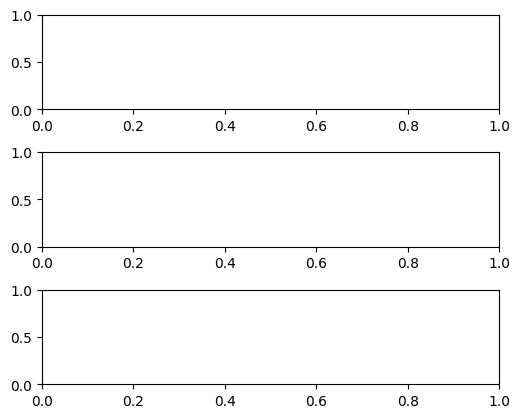

Game: 1 | Score: 1 | Total Moves: 122 | Collisions: 72 | Backtracks: 23 | Wins: 0 | Delta Time: 1.23 | Total Time: 1.23


error: display Surface quit

In [6]:
train()